# Álvaro Huertas García

## Notebook goals: 
This notebook shows a first classification approach with neural networks. A pre-processing is shown in which the label "bigram" is added over the words identified as bigram by Bag of Words in order to help the network understand that they are joint words. An example of the pre-processing is shown. This pre-processing is similar to the one done in the classic Machine learning models but without eliminating the stop words. 

The classification on the pre-processed text and on the text without any pre-processing is also shown. In this case RNN is used with LSTM with its own embeddings that it has to calculate. 


## Notebook' structure:
The structure of this notebook is:


* Load the modules

*   Load the data

    * Data visualization

*   Split the  data: train, test, validation and categorical label to one hot vector

*    <font color="orange">Pre-processing steps explained</font>

  *  <font color="orange">Bigrams</font>
  *  <font color="orange">Adding bigram on the text</font>
  *  <font color="orange">Trigram</font>
  *  <font color="orange">Toy example</font>

*   Pre-processing and filtering the text

*   Text to index

*   Padding

* Evaluation 
  * Single LSTM over pre-processed text
  * Single LSTM over raw data


In [0]:
COLAB = True
if COLAB:
    %tensorflow_version 1.x

## 1. Load modules

In [87]:
# Librerías de procesamiento de lenguaje

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

lemmatizer = WordNetLemmatizer().lemmatize
import gensim # pip install gensim
from gensim.models.word2vec import Word2Vec # word2vec model gensim class
TaggedDocument = gensim.models.doc2vec.TaggedDocument


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from tqdm import tqdm # pip install tqdm
pd.options.mode.chained_assignment = None
import collections
import re
from string import punctuation

from keras.datasets import imdb
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.layers.embeddings import Embedding
from keras import regularizers
from keras.constraints import UnitNorm
from keras.preprocessing import sequence
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer, one_hot # Codificar palabras a numeros
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances, cosine_distances

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool, LabelSet, ColumnDataSource, Range1d
from bokeh.plotting import figure, show, output_notebook

from gensim.models.word2vec import Word2Vec # word2vec model gensim class
from gensim.models.doc2vec import TaggedDocument

from IPython.display import SVG, clear_output
from keras.utils.vis_utils import model_to_dot
import pickle
import urllib

# fix random seed for reproducibility
np.random.seed(7)

%matplotlib inline

## Load data

In [0]:
if COLAB:
    import urllib
    # https://drive.google.com/file/d/1zJuh8XJTf_5hPZ8jVEUtGW1BnBZ6Yy4z/view?usp=sharing
    urllib.request.urlretrieve("https://drive.google.com/uc?export=download&id=1zJuh8XJTf_5hPZ8jVEUtGW1BnBZ6Yy4z",
                              "precision_medicine.zip")
    # https://drive.google.com/file/d/1PcVSBLgIpJVXAj4JD8_EQAGprte4zuyn/view?usp=sharing
    urllib.request.urlretrieve("https://drive.google.com/uc?export=download&id=1PcVSBLgIpJVXAj4JD8_EQAGprte4zuyn",
                              "long_stop_words.txt")

Para la extracción de bigrams vamos a emplear una lista de stop words más amplia obtenida de la siguiente fuente: https://countwordsfree.com/stopwords

In [105]:
f = open("long_stop_words.txt", "+r")
long_stopwords = f.read().split("\n")
len(long_stopwords)

853

In [0]:
!ls

In [0]:
!unzip precision_medicine.zip 

In [86]:
!ls precision_medicine

Alzheimer_abstracts.tsv       Cervical_Cancer_abstracts.tsv
Bladder_Cancer_abstracts.tsv  negative_abstracts.tsv
Breast_Cancer_abstracts.tsv


In [0]:
files = [('Alzheimer_abstracts.tsv', 'Alzheimer'),
         ('Bladder_Cancer_abstracts.tsv', 'Bladder Cancer'),
         ('Breast_Cancer_abstracts.tsv', 'Breast Cancer'),
         ('Cervical_Cancer_abstracts.tsv', 'Cervical Cancer'),
         ('negative_abstracts.tsv', 'Negative'),]

input_folder = './precision_medicine/'

In [0]:
def load_file(file_name):
    with open(file_name) as f:
        examples = []
        content = f.readlines()
        for l in content:
            aux = l.split('\t')
            examples.append((aux[0], (' '.join(aux[1:])).replace('\n', ' ')))
        return examples

### Data visualization

The first step we will take is to bring all the texts together. 
The variable `narratives` is a list with 5000 entries, where each entry is a document. 




In [0]:
# Variables donde almacenamos cada texto y su etiqueta
narratives = []
labels = []

# Para cada uno de los 5 archivos extraemos sus textos y le asignamos la etiqueta
for f,label in files:
    aux = load_file(input_folder + f)
    narratives.extend([x[1] for x in aux])
    labels.extend(len(aux)*[label])

labels = np.array(labels)

In [121]:
len(narratives), len(labels)

(5000, 5000)

At Natural Languege Processing (NLP) we can perform a "Label Consolidation" step on our data. This step aims to explore the initial classes of our problem and try to collapse similar classes into a single group. Consequently, the classification process is made easier since, first of all, the number of classes in which texts have to be classified is reduced and, furthermore, the classes have differentiable boundaries. 

In our case, this step is not necessary because we have 5 classes that are quite differentiated from each other and not redundant. 


In [99]:
print(len(narratives))
unique_labels, counts = np.unique(labels, return_counts=True)
for aa,bb in zip(unique_labels,counts):
    print(aa+':', bb)

5000
Alzheimer: 1000
Bladder Cancer: 1000
Breast Cancer: 1000
Cervical Cancer: 1000
Negative: 1000


We are interested in extracting from the different documents (abstract in this case) a vocabulary (`top_words`) that we will use later on in the recurrent network (RNN). To extract the vocabulary I need to gather all the data, but very important: **The vocabulary will only be generated
from the training data.**


## Train test data split

As mentioned above, the vocabulary (`top_words`) that will be used in the Recurrent Neuronal Network (RNN) will be extracted only from the training data (train) to avoid over-adjustment. Similarly, the cleaning of the texts will be done for training and test separately. [[1]](https://www.researchgate.net/post/Is_there_an_ideal_ratio_between_a_training_set_and_validation_set_Which_trade-off_would_you_suggest). [[2](https://stackoverflow.com/questions/54891464/is-it-better-to-keras-fit-to-text-on-the-entire-x-data-or-just-the-train-data)]



The division that will be used to extract the training data set will be: 70% for training data, the remaining 30% will be divided equally in two parts, 15% validation and 15% test.




In [90]:
from sklearn.model_selection import train_test_split

# Divido los datos en test&validación y entrenamiento
narratives_tr, narratives_te_val, y_tr, y_te_val = train_test_split(narratives, labels,
                                                            test_size=0.3, random_state=0, stratify =labels )

print("Number of test examples: {}".format(len(narratives_tr)))

# Dividimos test&validacion en test y validacion
narratives_te, narratives_val, y_te, y_val =  train_test_split(narratives_te_val, y_te_val,
                                                            test_size=0.5, random_state=0,  stratify = y_te_val)

print("Number of training examples: {} \nNumber of validation examples: {}".format(len(narratives_te), len(narratives_val)))

Number of test examples: 3500
Number of training examples: 750 
Number of validation examples: 750


In [98]:
collections.Counter(y_tr)

Counter({'Alzheimer': 700,
         'Bladder Cancer': 700,
         'Breast Cancer': 700,
         'Cervical Cancer': 700,
         'Negative': 700})

We can see how the training data is balanced between the different classes

Since it is a multi-label classification, so the output labels need to be one-hot encoded. We have used Bag of words technique using the sci-kit learn method for this.



In [0]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(","), binary= False)
y_tr_num = vectorizer.fit_transform(y_tr)
y_val_num = vectorizer.fit_transform(y_val)
y_te_num = vectorizer.fit_transform(y_te)

Now `label_num` is a sparse matrix, but we can check how the codification looks like with `todense()`. Now the labels are one hot vectors with length equal to all the 5 different classes. 

In [0]:
y_tr_num.todense()

## Pre-processing steps explained

<font color="orange"><h1 align="left">
------ BEGIN Examples ------

</h1></font>

In this section the different step of pre-processing are explained. In order to show the usefulness of the pre-processing steps carried out, the steps are applied in all the text joined. 


In [91]:
mycorpora = ' '.join(narratives_tr)
print(len(mycorpora))
print(mycorpora[:1000])

5660027
Do invitations for cervical screening provide sufficient information to enable informed choice? A cross-sectional study of invitations for publicly funded cervical screening. OBJECTIVE: To investigate whether invitations for publicly funded cervical screening provide sufficient information to enable an informed choice about participation. DESIGN: Cross-sectional study using a checklist of 23 information items on benefits and harms from cervical screening and the risks related to cervical cancer. MATERIAL: Invitations to publicly funded cervical screening in 10 Scandinavian and English-speaking countries. SETTING: Ten Scandinavian and English speaking countries. PARTICIPANTS: Sixteen screening units representing 10 Scandinavian and English speaking countries. MAIN OUTCOME MEASURES: Number of information items presented in invitations for cervical screening. RESULTS: We contacted 21 coordinating units from 11 countries and 20 (95%) responded. Of these, four units did not issue in

To check that the substitution is done correctly, we use as a control the protein P53, considered as the _guardian of the genome_ and whose alteration plays a fundamental role in the development of different types of cancer. This number must remain the same after all the pre-processing steps. 

In [97]:
print("CHECK POINT! Initial number of P53 in the text:", len(re.findall(r"P53", mycorpora)))

CHECK POINT! Initial number of P53 in the text: 28


In [94]:
# Eliminar elementos introductorios de los apartados: BACKGROUND, METHODS ...
print(re.findall("[A-Z]+:", mycorpora))
print("Initial number of name sections:", len(re.findall("[A-Z]+:", mycorpora)))
text = re.sub("[A-Z]+:", "", mycorpora)
print("Number of name sections after substitution:", len(re.findall("[A-Z]+:", text)))
print("CHECK POINT! Number of P53 after substitution:", len(re.findall(r"P53", text)))

['OBJECTIVE:', 'DESIGN:', 'MATERIAL:', 'SETTING:', 'PARTICIPANTS:', 'MEASURES:', 'RESULTS:', 'CONCLUSIONS:', 'OBJECTIVE:', 'METHODS:', 'RESULTS:', 'CONCLUSIONS:', 'OBJECTIVES:', 'METHODS:', 'RESULTS:', 'CONCLUSIONS:', 'OBJECTIVES:', 'DESIGN:', 'RESULTS:', 'CONCLUSIONS:', 'PURPOSE:', 'METHODS:', 'RESULTS:', 'CONCLUSIONS:', 'PURPOSE:', 'METHODS:', 'RESULTS:', 'CONCLUSION:', 'INTRODUCTION:', 'REPORT:', 'DISCUSSION:', 'OBJECTIVE:', 'METHODS:', 'RESULTS:', 'CONCLUSION:', 'AIM:', 'METHOD:', 'RESULT:', 'CONCLUSION:', 'PURPOSE:', 'METHODS:', 'RESULTS:', 'CI:', 'CI:', 'CI:', 'CI:', 'CONCLUSIONS:', 'BACKGROUND:', 'METHODS:', 'RESULTS:', 'CONCLUSIONS:', 'OBJECTIVES:', 'METHODS:', 'RESULTS:', 'CONCLUSIONS:', 'LR:', 'CI:', 'CI:', 'CI:', 'OBJECTIVE:', 'METHODS:', 'RESULTS:', 'CONCLUSIONS:', 'PURPOSE:', 'METHODS:', 'RESULTS:', 'CONCLUSIONS:', 'OBJECTIVES:', 'METHODS:', 'RESULTS:', 'CONCLUSIONS:', 'BACKGROUND:', 'RESULTS:', 'CONCLUSION:', 'BACKGROUND:', 'METHODS:', 'RESULTS:', 'CONCLUSIONS:', 'OBJECTI

In [81]:
print("Number of 'e-mail' replaced:", len(re.findall(r"e\s?-\s?mail", text)))
text = re.sub(r"e\s?-\s?mail", "email", text)
print("CHECK POINT! Number of P53 after substitution:", len(re.findall(r"P53", text)))

Number of 'e-mail' replaced: 0
CHECK POINT! Number of P53 after substitution: 0


In [82]:
HPPV = len(re.findall('hhpv', text)) # High Priority P Value
LPPV = len(re.findall('llpv', text)) # Low Priority P Value

# total_p_valor = len(re.findall('p\s?[>=<]\s?[\d]+', text))
# print("Initial number of p values:", total_p_valor)

print('Initial number of  hppv:', HPPV, "and lppv:", LPPV)
print()

# Sustituimos los p valores menores que 0.05 por SIG
print(re.findall('p\s?[<=]\s?0?[.,]0[0-5]+', text))
text = re.sub('p\s?[<=]\s?0?[.,]0[0-5]+', 'hppv', text)
print("Number of significant p values replaced by hppv:", len(re.findall("hppv", text)))
print("Number of hppv:", len(re.findall("hppv", text)))
print("Number of lppv:", len(re.findall("lppv", text)))
print("CHECK POINT! Number of P53 after substitution:", len(re.findall(r"P53", text)))


Initial number of  hppv: 0 and lppv: 0

[]
Number of significant p values replaced by hppv: 0
Number of hppv: 0
Number of lppv: 0
CHECK POINT! Number of P53 after substitution: 0


In [102]:
# Sustituimos los p valores mayores o iguales que 0.05 por INSIG
print(re.findall('p\s?[>=]\s?[\d]+[.,]?\d*', text))
text = re.sub('p\s?[>=]\s?[\d]+[.,]?\d*', 'lppv', text)
print("Number of non significant p values replaced by lppv:", len(re.findall("lppv", text)))
print("Nº P53 after substitution:", len(re.findall(r"P53", text)))

print("Number of hppv:", len(re.findall("hppv", text)))
print("Number of lppv:", len(re.findall("lppv", text)))
print("CHECK POINT! Number of P53 after substitution:", len(re.findall(r"P53", text)))

['p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p > 18', 'p > 18', 'p > 18', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 5', 'p = 0', 'p = 0', 'p = 0', 'p = 1', 'p = 0', 'p = 0', 'p = 0', 'p = 9', 'p = 0', 'p = 0', 'p = 0', 'p = 1', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p > 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0', 'p = 0

## Bigram

To help the neural network understand that there are words that always go together and that the meaning in the text is obtained by the joint action of both words, I will look for the bigrams present throughout the texts. To do this I will use the whole of the texts together (`mycorpora`). On this body I will tokenize and make some filtering to facilitate the extraction of bigrams. Among the filtering steps are the elimination of the _stop words_, the _score_ and the numbers.

We are interested in bigrams because they can make it easier for the neural network to learn from the text. To facilitate this learning our goal is to add a term next to the words that form a bigram so that every time you see a bigram that term is repeated and you are told that what you have visualized is a bigram.

We must never forget that the neural network will not receive 'mycorpora' but a text at each time. For this I will then apply a pre-processing on each text. However, the pre-processing will be done with the information of all the texts. The bigrams are a clear example of this, since the bigrams are obtained from the study of all the texts as a whole, but they will serve us to carry out a preprocessing of each text individually.

We will make a first extraction of all the texts without pre-processing. We see that not all bigrams are biologically relevant.

In [0]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(narratives_tr, 20)


In [0]:
def count_bigram(vocab, docs, topn = 10):
  '''Extract topn frequent bigrams '''
  lista = []
  bigrams = list(vocab.keys())
  for i in bigrams:
    apariciones = 0
    for texto in docs:
      apariciones += len(re.findall(i, texto.lower()))
    lista.append( (i, apariciones) )
  ordenada = sorted(lista, key = lambda k: k[1], reverse=True)
  return ordenada[:topn]

In [0]:
def my_cool_preprocessor(text):
  '''Pre-process text for extract bigrams'''

  text = re.sub(r"[A-Z]+:", "", text)
  tokenized_text = nltk.word_tokenize(text)
  

  tokenized_text = [i.lower() for i in tokenized_text if i != " NUM "]

  from string import punctuation
  stop_words = set(long_stopwords) # using a bigger one +800 words
  punctuation_marks = set(punctuation)

  tokenized_text = [i for i in tokenized_text if i not in punctuation_marks]
  tokenized_text = [i for i in tokenized_text if i not in stop_words]

  # Lemmanizamos, dado que queremos los bigram en singular
  tokenized_text = [lemmatizer(word) for word in tokenized_text]
  full_text = ' '.join(tokenized_text)
  return full_text


Since we have 5 different types of text, the bigrams we want to identify must also be specific or more common terms in an area. For example, some terms between Alzheimer's and cancer will be common, but others will not. In order to capture biologically relevant bigrams we will ignore terms that appear in 80% of the documents (2800) (`max_df = 0.95`) and ignore terms that appeared in less than 35 documents (1%, `min_df = 0.01`) (this value has been optimized by observing the results with different possible values). Furthermore, to speed up the process the number of bigrams to extract has been stablished to a maximum of 10000 (`max_features = 10000`). 


In [0]:
# ignore terms that appeared in less than 2 documents 
# ignore terms that appear in 95% of the documents
cv = CountVectorizer(narratives_tr, ngram_range=(2,2), min_df=0.01, max_df=0.95, preprocessor=my_cool_preprocessor, max_features=10000)
count_vector=cv.fit_transform(narratives_tr)

# See the bigrams found among the documents
#cv.vocabulary_

# See the words ignored in the bigram search
# cv.stop_words_

In [0]:
# Extract topn bigrams
bigrams = count_bigram(cv.vocabulary_, narratives_tr, topn = 100)

Visualization of bigrams after pre-processing the text. We can see that the pre-processig process is usefull to extract relevant biological bigrams. 


In [124]:
import plotly.graph_objects as go 
y_values = [i[1] for i in bigrams[:20]]
x_values = [i[0] for i in bigrams[:20]]
fig = go.Figure(
    data=[go.Bar(x = x_values, y= y_values)],
    layout_title_text="Top 20 bigrams after pre-processing",
)
fig.show()

## Adding bigram on the text

First we are going to establish a term to add to the bigrams that is not previously in the text. 

In [84]:
re.findall("bigram", mycorpora)

['bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',
 'bigram',

Ahora vamos a sustituir los bigrams por el bigram más el término "bigram". Hay que recordar que los bigrams generados están lemmanizados y, por tanto, los bigrams como "cancer cells" han sido transformados en "cancer cell". A continuación, sustituimos los bigrams originales en el texto por el bigram añadiéndole el término "bigram":

* _breast cancer_ $\rightarrow$ _bigram breast cancer_
* _cancer cell_ $\rightarrow$ _bigram cancer cell_
* _cancer cells_ $\rightarrow$ _bigram cancer cell_

Dado que en nuestro caso el interés se encuentra en facilitar a la red neuronal para que identifique la entidad biológica este error es asumible, frente al error que supondría no sustituir las entidades biológicas en plural. En otras palabras, priorizamos la información procedente de la entidad biológica que el plural o singular. 


In [93]:
# In case you run it again
mycorpora = ' '.join(narratives_tr)

# Example at the beggining
example = re.findall(".{20}breast cancer.{20}", mycorpora)
print("Initially -->", example[0])

for tupla in bigrams:
  bigram = tupla[0]
  # print(bigram)
  # print("Antes", len(re.findall(rf"{bigram}", mycorpora)))
  mycorpora = re.sub(rf"{bigram}s?", rf"bigram {bigram}", mycorpora)
  # print("Después", len(re.findall(rf"bigram {bigram}", mycorpora)))

# Check the change
example = re.findall(".{20}breast cancer.{20}", mycorpora)
print("Transformed -->", example[0])

Initially --> n receptor-negative breast cancer. Risk biomarkers fo
Transformed --> tor-bigram negative breast cancer. Risk biomarkers fo


## Trigrams

In the case of trigrams, we can observe that the are not as useful as brigrams. Firstly, they do not appear as frequently as bigrams, so the balance between the risk or the benefit of substituing them is not worth enough. Secondly, the most common trigmas are already bigrams. For example, "breas cancer cell" is a trigram (271 appearences)  and "breast cancer" is a bigram (1926 appearances). It is preferred to associete only "breast" with "cancer" and do not incluce "cell", because in 1655 appeareces of "breast cancer" it does not appear with the term "cell". Furthermore, the interesting biology entity is "breast cancer", and the term "cell" can lead into the loss of the biology signal in the text. 

In [0]:
cv = CountVectorizer(narratives_tr, ngram_range=(3,3), min_df=0.01, max_df=0.95, preprocessor=my_cool_preprocessor, max_features=10000)
count_vector=cv.fit_transform(narratives_tr)

In [0]:
# Extract topn bigrams
trigrams = count_bigram(cv.vocabulary_, narratives_tr, topn = 100)

In [96]:
y_values = [i[1] for i in trigrams[:20]]
x_values = [i[0] for i in trigrams[:20]]
fig = go.Figure(
    data=[go.Bar(x = x_values, y= y_values)],
    layout_title_text="Top 20 bigrams after pre-processing",
)
fig.show()



At Deep Learing we want our recurring neural network to be able to perceive the ideas conveyed by a sentence or paragraphs and how these elements relate to each other. To do this, the connectors (such as the connectors of comparison, order, exemplification, conditionals, explanation ...) we want to remain intact. For this reason, in Deep Learning the punctuation marks or stop words will not be eliminated. 

However, in order to facilitate the extraction of these patterns from the neural network, I consider it logical to separate the alphabetic elements from the punctuation marks. For that reason, we will add one spaces at both sides of each punctuation marks. 

We will use the punctuation marks from `string` module, and we will include the ASCII elemente 177, which belong to: "±" (widely used in scientific studies for giving the error). 

This step is done before the numbers are replaced because it makes it easier for terms like "ds53-238" or "(20)" or "[234]" to be replaced correctly (as will be shown in a toy example later). 


In [95]:
punctuation_marks = set(punctuation)
punctuation_marks = set(punctuation)
for i in punctuation_marks:
  element = "\\"+i
  sub_element = " "+i+" " # Example "=" --> " = "
  x = len(re.findall(element, text))
  print("Number of {0} in the text: {1}".format(element[-1:], x))
  text = re.sub(element, sub_element, text)

Number of @ in the text: 20
Number of { in the text: 11
Number of | in the text: 0
Number of \ in the text: 0
Number of ^ in the text: 1
Number of ! in the text: 0
Number of : in the text: 2303
Number of ) in the text: 18125
Number of ; in the text: 2367
Number of [ in the text: 854
Number of + in the text: 1317
Number of _ in the text: 40
Number of # in the text: 2
Number of / in the text: 4860
Number of $ in the text: 32
Number of - in the text: 29887
Number of = in the text: 3108
Number of ( in the text: 18093
Number of < in the text: 1156
Number of * in the text: 203
Number of & in the text: 114
Number of . in the text: 51006
Number of > in the text: 546
Number of ] in the text: 857
Number of ' in the text: 2266
Number of " in the text: 573
Number of ~ in the text: 53
Number of , in the text: 39607
Number of } in the text: 11
Number of % in the text: 6120
Number of ` in the text: 0
Number of ? in the text: 122


In [103]:
from string import punctuation
punctuation_marks = set(punctuation)
# Include ± 
punctuation_marks.update(chr(177))


for i in punctuation_marks:
  element = "\\"+i # scape the character
  if element in  ["\\/", "\\+", "\\-", "\\=", "\\>", "\\<"]: # We do not change "+/-", "-/+". "</=" .. 
    sub_element = " "+i+" "
    text = re.sub(rf"[^+-=<>]{element}[^+-=<>]", rf" {sub_element} ", text)
  else:
    sub_element = " "+i+" " # Example "=" --> " = "
    text = re.sub(element, sub_element, text)
  x = len(re.findall(element, text))
  print("Number of {0} in the text: {1}".format(element[-1:], x))
  text = re.sub(element, sub_element, text)

Number of @ in the text: 20
Number of { in the text: 11
Number of | in the text: 0
Number of \ in the text: 0
Number of ^ in the text: 1
Number of ! in the text: 0
Number of : in the text: 2303
Number of ) in the text: 18125
Number of ; in the text: 2367
Number of [ in the text: 854
Number of + in the text: 1317
Number of _ in the text: 40
Number of ± in the text: 0
Number of # in the text: 2
Number of / in the text: 4860
Number of $ in the text: 32
Number of - in the text: 29887
Number of = in the text: 2908
Number of ( in the text: 18093
Number of < in the text: 1156
Number of * in the text: 203
Number of & in the text: 114
Number of . in the text: 51006
Number of > in the text: 541
Number of ] in the text: 857
Number of ' in the text: 2266
Number of " in the text: 573
Number of ~ in the text: 53
Number of , in the text: 39607
Number of } in the text: 11
Number of % in the text: 6120
Number of ` in the text: 0
Number of ? in the text: 122


In [114]:
print("CHECK POINT! Number of P53 after substitution:", len(re.findall(r"P53", text)))

CHECK POINT! Number of P53 after substitution: 0


We will now replace the numbers in the text with the term " NUM ". It is important to note that numbers that are part of proteins or other terms we want to remain intact.

In [109]:
# Nos interesa
print("Important. Not to delete:", re.findall('[A-Za-z][\-~]?[1-9][0-9]*\.?[0-9]+', text))
# No nos interesa, 
print("Not important. Delete:", re.findall('[^A-Za-z][\-]?[1-9][0-9]*\.?[0-9]+', text))
print("Visualization of not important:", re.findall('.{5}[^A-Za-z][\-]?[1-9][0-9]*\.?[0-9]+.{5}', text))

Important. Not to delete: []
Not important. Delete: []
Visualization of not important: []


In [112]:
print(re.findall(r".{5}P53.{5}", text))
print("Number of element replaced by ' NUM ': ", len(re.findall('[^A-Za-z][\-]?[1-9][0-9]*\.?[0-9]*', text)))
text = re.sub( '[^A-Za-z][\-~]?[1-9][0-9]*\s?\.?\s?[0-9]+', " NUM ", text)
text = re.sub( ' (\d)[^A-Za-z]', " NUM ", text)
print(re.findall(r".{5}P53.{5}", text))
print("CHECK POINT! Number of P53 after substitution:", len(re.findall(r"P53", text)))

[]
Number of element replaced by ' NUM ':  0
[]
CHECK POINT! Number of P53 after substitution: 0


Since several non-letter elements can be found adjacent to each other in the text, with the above substitution two spaces would have been incorporated between these elements, resulting in a text with many empty elements corresponding to spaces. We note that we went from 3499 repeated spaces to 359792. To avoid this we will reduce the spaces between text elements by one space. 

In [120]:
print("Number of more than one space initially", len(re.findall(r"\s{2,}", mycorpora)))
print("Number of spaces higher than one:", len(re.findall(r"\s{2,}", text)))
text = re.sub(r"\s{2,}", " ", text)
print("Number of spaces higher than one:", len(re.findall(r"\s{2,}", text)))
print("CHECK POINT! Number of P53 after substitution:", len(re.findall(r"P53", text)))

Number of more than one space initially 3499
Number of spaces higher than one: 0
Number of spaces higher than one: 0
CHECK POINT! Number of P53 after substitution: 0


Finally, we check that the number of P53 elements remain the same. 

In [0]:
print("CHECK POINT! Number of P53 after substitution:", len(re.findall(r"P53", text)))

We can see that the protein TP53 and the small RNA ds53 has not changed, while the rest of the numbers has changed to NUM. Morevover, by compressing the double spaces we keep the length of the sentence similar to the original, and the elements "+/-" or "±" stay close in the text to make easier the comprehension.  


### Toy example

Here I show in a toy example how the regular expression used before to subtitute number by NUM change the text. Note that the numbers are separated from the punctuation marks due to the previous step of separating the punctuation marks.

**The** only problem we find is the alteration of the chemical formulation of compounds ( N,N,N'-triethyl-1,2-ethanediamine --> N , N , N ' - triethyl - NUM - ethanediamine). Depending on the objective of the study this can be a drawback. 

In [123]:
cadena = "Mix 17F 0,8 grams of CH3NO2 with 4.6 ml of amoniac (NH3) and 56.8 mg of N,N,N'-trietil-1,2-etanodiamina reference [345].  The oncogen TP53 and small RNA ds53-238 show effect with 18F-fluorodeoxyglucose (18F-FDG) after 5 or  </= 4 hours and 6-7 minutes. For that 1003,05±24 or 1003,05 +/- 24 people in ~1906."
print(cadena)


punctuation_marks = set(punctuation)
punctuation_marks.update(chr(177))
punctuation_marks.update("+/-")

for i in punctuation_marks:
  element = "\\"+i # scape the character
  sub_element = " "+i+" " # Example "=" --> " = "
  cadena = re.sub(element, sub_element, cadena)

print(cadena)

# '[^A-Za-z][\-~]?[0-9][0-9]*\s?[.,]?\s?[0-9]+' '[^A-Za-z][\-~]?[0-9][0-9]*\s?[.,]?\s?[0-9]+[^A-Za-z]'
cadena = re.sub( '[^A-Za-z][\-~]?[0-9][0-9]*\s?[.,]?\s?[0-9]+[^A-Za-z]', " NUM ", cadena)
cadena = re.sub( "\s[0-9]+\s", " NUM ", cadena)
print(cadena)

cadena = re.sub(r"\s{2,}", " ", cadena)
print(cadena)

Mix 17F 0,8 grams of CH3NO2 with 4.6 ml of amoniac (NH3) and 56.8 mg of N,N,N'-trietil-1,2-etanodiamina reference [345].  The oncogen TP53 and small RNA ds53-238 show effect with 18F-fluorodeoxyglucose (18F-FDG) after 5 or  </= 4 hours and 6-7 minutes. For that 1003,05±24 or 1003,05 +/- 24 people in ~1906.
Mix 17F 0 , 8 grams of CH3NO2 with 4 . 6 ml of amoniac  ( NH3 )  and 56 . 8 mg of N , N , N '  - trietil - 1 , 2 - etanodiamina reference  [ 345 ]  .   The oncogen TP53 and small RNA ds53 - 238 show effect with 18F - fluorodeoxyglucose  ( 18F - FDG )  after 5 or   <  /  =  4 hours and 6 - 7 minutes .  For that 1003 , 05 ± 24 or 1003 , 05  +  /  -  24 people in  ~ 1906 . 
Mix 17F NUM grams of CH3NO2 with NUM ml of amoniac  ( NH3 )  and NUM mg of N , N , N '  - trietil - NUM - etanodiamina reference  [ NUM ]  .   The oncogen TP53 and small RNA ds53 - NUM show effect with 18F - fluorodeoxyglucose  ( 18F - FDG )  after NUM or   <  /  =  NUM hours and NUM - NUM minutes .  For that NUM ± N

<font color="orange"><h1 align="left">
------ END Examples ------
</h1></font>

# Pre-processing and filtering text

In Deep Learning it is necessary to keep the texts separate, since at each time of the sequence a text will be an input. 

For this reason we generated a function that will apply all the previously seen filtering steps to each text individually. 

To avoid overfitting we will pre-process all data splits (train, test and validation) with the same pipeline obtained from the study of training data. 

In [0]:
from string import punctuation
def clean_text(text, bigrams):

  # Sections
  text = re.sub("[A-Z]{0,}\s[A-Z]+:", "", text) # se te cuelan lo Background

  # Lowercase
  text=text.lower()

  # E mail
  text = re.sub(r"e\s?-\s?mail", "email", text)

  # P value
  text = re.sub('p\s?[<=]\s?0?[.,]0[0-5]+', 'hppv', text) # Significant
  text = re.sub('p\s?[>=]\s?[\d]+[.,]?\d*', 'lppv', text) # Non-significant


  # Bigrams
  for tupla in bigrams:
    bigram = tupla[0]
    text = re.sub(rf"{bigram}s?", rf"bigram {bigram}", text)
  
  # Punctuation
  punctuation_marks = set(punctuation)
  punctuation_marks.update(chr(177))

  for i in punctuation_marks:
    element = "\\"+i # scape the character
    sub_element = " "+i+" " # Example "=" --> " = "
    text = re.sub(element, sub_element, text)

  # Numbers '[^A-Za-z][\-~]?[0-9][0-9]*\s?[.,]?\s?[0-9]+', " NUM ", '[^A-Za-z][\-~]?[1-9][0-9]*\s?\.?\s?[0-9]+', " NUM "
  text = re.sub( '[^A-Za-z][\-~]?[0-9][0-9]*\s?[.,]?\s?[0-9]+[^A-Za-z]', " num ", text)
  
  text = re.sub( "\s[0-9]+\s", " num ", text)

  # Double to single space
  text = re.sub(r"\s{2,}", " ", text)
  

  

  return text

In [0]:
# New variable where we collect the clean training data
clean_tr = []

# In each iteration a text is cleaned
i = 0
for text in narratives_tr:
  clean = clean_text( text, bigrams ) 
  clean_tr.append( clean )

In [119]:
print(narratives_tr[0])
print(clean_tr[0])

Do invitations for cervical screening provide sufficient information to enable informed choice? A cross-sectional study of invitations for publicly funded cervical screening. OBJECTIVE: To investigate whether invitations for publicly funded cervical screening provide sufficient information to enable an informed choice about participation. DESIGN: Cross-sectional study using a checklist of 23 information items on benefits and harms from cervical screening and the risks related to cervical cancer. MATERIAL: Invitations to publicly funded cervical screening in 10 Scandinavian and English-speaking countries. SETTING: Ten Scandinavian and English speaking countries. PARTICIPANTS: Sixteen screening units representing 10 Scandinavian and English speaking countries. MAIN OUTCOME MEASURES: Number of information items presented in invitations for cervical screening. RESULTS: We contacted 21 coordinating units from 11 countries and 20 (95%) responded. Of these, four units did not issue invitation

In [104]:
print(narratives_tr[453])
print(clean_tr[453])

False-Positive Error Rates for Reliable Digit Span and Auditory Verbal Learning Test Performance Validity Measures in Amnestic Mild Cognitive Impairment and Early Alzheimer Disease. OBJECTIVE: The objective is to examine failure on three embedded performance validity tests [Reliable Digit Span (RDS), Auditory Verbal Learning Test (AVLT) logistic regression, and AVLT recognition memory] in early Alzheimer disease (AD; n = 178), amnestic mild cognitive impairment (MCI; n = 365), and cognitively intact age-matched controls (n = 206). METHOD: Neuropsychological tests scores were obtained from subjects participating in the Alzheimer's Disease Neuroimaging Initiative (ADNI). RESULTS: RDS failure using a </=7 RDS threshold was 60/178 (34%) for early AD, 52/365 (14%) for MCI, and 17/206 (8%) for controls. A </=6 RDS criterion reduced this rate to 24/178 (13%) for early AD, 15/365 (4%) for MCI, and 7/206 (3%) for controls. AVLT logistic regression probability of >/=.76 yielded unacceptably high

In [0]:
print(narratives_tr[555])
print(clean_tr[555])

In [0]:
# New variable where we collect the clean test data
clean_te = []

# In each iteration a text is cleaned
for text in narratives_te:
  clean = clean_text( text, bigrams ) 
  clean_te.append( clean )

In [110]:
print(narratives_te[555])
print(clean_te[555])

Study of phytochemical, anti-microbial, anti-oxidant, and anti-cancer properties of Allium wallichii. BACKGROUND: There is growing interest in the use of plants for the treatment and prevention of cancer. Medicinal plants are currently being evaluated as source of promising anticancer agents. In this paper, we have investigated the anticancer potential of plant Allium wallichii, a plant native to Nepal and growing at elevations of 2300-4800 m. This is the first study of its kind for the plant mentioned. METHODS: The dried plant was extracted in aqueous ethanol. Phytochemical screening, anti-microbial assay, anti-oxidant assay, cytotoxicity assay and the flow-cytometric analysis were done for analyzing different phytochemicals present, anti-microbial activity, anti-oxidant activity and anti-cancer properties of Allium wallichii. RESULTS: We observed the presence of steroids, terpenoids, flavonoids, reducing sugars and glycosides in the plant extract and the plant showed moderate anti-mi

In [0]:
# New variable where we collect the clean test data
clean_val = []

# In each iteration a text is cleaned
for text in narratives_val:
  clean = clean_text( text, bigrams ) 
  clean_val.append( clean )

In [118]:
print(narratives_val[57])
print(clean_val[57])

Evaluation of the cost of cervical cancer at the National Institute of Oncology, Rabat. INTRODUCTION: The Cervical Cancer (CC) is one of the heavy and costly diseases for the population and the health system. We want to know through this study, the first in Morocco, the annual cost of the treatment of this disease at the National Institute of Oncology (NIO) in Rabat, we also want to explore the possibility of flat-rate management of this disease in order to standardize medical practices and improve reimbursement by health insurance funds. METHODS: 550 patients were treated for their cervical cancer in the Rabat's NIO. Data of all of medical and surgical services offered to patients were collected from the NIO registry. The cost of care was assessed using the method of micro-costing. We will focus to the total direct cost of all the services lavished to patients in NIO. RESULTS: The global cost was about US$ 1,429,673 with an average estimated at US$ 2,599 +/- US$ 839. Radiotherapy acco

# Text to index

<font color="orange"><h1 align="left">Text to index</h1></font>


Keras provides a more sophisticated API for preparing text that can be fit and reused to prepare multiple text documents. Keras provides the Tokenizer class for preparing text documents for deep learning. The Tokenizer must be constructed and then fit on either raw text documents or integer encoded text documents.

If you're not aware already, max_features corresponds to the number of unique words you're interested in. 95000 is far less than the total number of unique words in the training set. This is over 200,000 words depending on how you do your cleaning.
[2](https://stackoverflow.com/questions/38156017/defining-vocabulary-size-in-text-classification) [3](https://towardsdatascience.com/text-classification-using-k-nearest-neighbors-46fa8a77acc5) [4](https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/)]
[[5](https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/)]




Number of total words

In [106]:
num_total = 0
for i in range(len(clean_tr)):
  num_total += len(clean_tr[i])

print("Total number of words in clean train texts: ", num_total)

Total number of words in clean train texts:  5916868


We can see the number of unique words and check tha t "oov" is not present in the original vocabulary. It will be added in the "Text to index" step. 

In [116]:
clean_tr_corpus = nltk.word_tokenize(" ".join(clean_tr))
print("Number of uniques words:", len(set(clean_tr_corpus)))

Number of uniques words: 28533


In [0]:
re.findall(" oov ", mycorpora)

In [0]:
# Length of the vocabulary
top_words =  10000

tokenizer = Tokenizer(num_words = top_words,   oov_token = "oov")
tokenizer.fit_on_texts(clean_tr)
X_train = np.array(tokenizer.texts_to_sequences(clean_tr))
X_test = np.array(tokenizer.texts_to_sequences(clean_te))
X_val = np.array(tokenizer.texts_to_sequences(clean_val))

In [0]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

In [0]:
word2int = tokenizer.word_index
int2word = {v: k for k, v in word2int.items()}
print(word2int)
print(int2word)

Here we show the original first document and how it looks after pre-processing and sequencing it. For instance, we can check that some words are now classified as "oov": 

* Original: "potential applications for a configured model"

* Sequenced: "4, 114, 60, 4586, 1, 63"

* Translation from sequencing: "potential applications for a oov model "

In [111]:
ejemplo = 0
print(narratives_tr[ejemplo])
print(X_train[ejemplo])
print(tokenizer.sequences_to_texts([X_train[ejemplo]]))
# for i,x in enumerate(X_train[ejemplo][:50]):
  # print("{} -> {}".format(x, int2word[x]))

Do invitations for cervical screening provide sufficient information to enable informed choice? A cross-sectional study of invitations for publicly funded cervical screening. OBJECTIVE: To investigate whether invitations for publicly funded cervical screening provide sufficient information to enable an informed choice about participation. DESIGN: Cross-sectional study using a checklist of 23 information items on benefits and harms from cervical screening and the risks related to cervical cancer. MATERIAL: Invitations to publicly funded cervical screening in 10 Scandinavian and English-speaking countries. SETTING: Ten Scandinavian and English speaking countries. PARTICIPANTS: Sixteen screening units representing 10 Scandinavian and English speaking countries. MAIN OUTCOME MEASURES: Number of information items presented in invitations for cervical screening. RESULTS: We contacted 21 coordinating units from 11 countries and 20 (95%) responded. Of these, four units did not issue invitation

Once fit, the Tokenizer provides 4 attributes that you can use to query what has been learned about your documents:

    

1.   `word_counts`: A dictionary of words and their counts.
2.   `word_docs`: A dictionary of words and how many documents each appeared in.
3. `word_index`: A dictionary of words and their uniquely assigned integers.
4. `document_count`:An integer count of the total number of documents that were used to fit the Tokenizer.



In [0]:
tokenizer.word_counts["p53"]

In [122]:
# summarize what was learned
print(tokenizer.word_counts)
print(tokenizer.document_count)
print(tokenizer.word_index)
print(tokenizer.word_docs)

OrderedDict([('do', 100), ('invitations', 13), ('for', 8905), ('cervical', 2354), ('screening', 601), ('provide', 320), ('sufficient', 49), ('information', 302), ('to', 14111), ('enable', 30), ('informed', 25), ('choice', 58), ('a', 12375), ('cross', 173), ('sectional', 92), ('study', 2786), ('of', 33822), ('publicly', 12), ('funded', 8), ('investigate', 341), ('whether', 320), ('an', 2558), ('about', 337), ('participation', 42), ('using', 1651), ('checklist', 12), ('num', 35443), ('items', 58), ('on', 3897), ('benefits', 85), ('and', 31413), ('harms', 16), ('from', 3006), ('the', 36931), ('risks', 80), ('related', 782), ('cancer', 7317), ('in', 22620), ('scandinavian', 4), ('english', 43), ('speaking', 21), ('countries', 140), ('ten', 68), ('sixteen', 11), ('units', 40), ('representing', 27), ('main', 225), ('number', 453), ('presented', 209), ('we', 3115), ('contacted', 6), ('coordinating', 4), ('responded', 12), ('these', 1632), ('four', 302), ('did', 280), ('not', 1491), ('issue', 


We can see the top 50 words most common in the train data set. 

In [126]:
w = tokenizer.word_counts
vocab = sorted(w.items(), key = lambda x: x[1], reverse=True)
ordenado = collections.OrderedDict(vocab)
top_palabras = list(ordenado.items())[:50]
palabras = [i[0] for i in top_palabras]
counts = [i[1] for i in top_palabras]
# (top_palabras)
# vocab = [i[0] for i in vocab]
fig = go.Figure(
    data=[go.Bar(x = palabras, y= counts)],
    layout_title_text="Top 50 words in clean train texts",
)
fig.show()

# Padding 

<font color="orange"><h1 align="left">Padding </h1></font>

Keras requiere that all the data that is used as input has the same length. That requires that the data has to be transformed adding 0 for filling empty data in some texts. 



In [144]:
doc_len = np.zeros(len(X_train))
for i in range(len(X_train)):
  doc_len[i] = len(X_train[i])

print("Average length of the train texts:", np.mean(doc_len))
print("Standar deviation:", np.std(doc_len))

Average length of the train texts: 240.55742857142857
Standar deviation: 89.09223704655297


In [0]:
maxlen = 250
X_train_pad = pad_sequences(X_train, maxlen=maxlen)
X_test_pad = pad_sequences(X_test, maxlen=maxlen)
X_val_pad = pad_sequences(X_val, maxlen=maxlen)

# Add the padding element
int2word[0] = "padding"

# Evaluation



In [0]:
def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

def visualiza_procesamiento_LSTM(seq, y, text, interpretacion_sentimientos, model2, alpha=0.2):
    plt.figure(figsize=(15,15))
    plt.plot(sals_finales_pca_tr[inds_0,0],
             sals_finales_pca_tr[inds_0,1], '.r', alpha=alpha/2)
    plt.plot(sals_finales_pca_tr[inds_0[-1],0],
             sals_finales_pca_tr[inds_0[-1],1], '.r',
             label="Sentimiento "+interpretacion_sentimientos[0])
    plt.plot(sals_finales_pca_tr[inds_1,0],
             sals_finales_pca_tr[inds_1,1], '.', alpha=alpha)
    plt.plot(sals_finales_pca_tr[inds_1[-1],0],
             sals_finales_pca_tr[inds_1[-1],1], '.b',
             label="Sentimiento "+interpretacion_sentimientos[1])
    text_aux = [int2word[x] for x in seq]
    aux = pca.transform(model2.predict(np.array([seq]))[0])
    plt.plot(aux[:,0], aux[:,1])
    for x,w in zip(aux,text_aux):
        plt.text(x[0],x[1],w)
    plt.plot(aux[0,0],aux[0,1],'og',markersize=40,alpha=0.5)
    plt.plot(aux[0,0],aux[0,1],'og',label="Start")
    plt.plot(aux[-1,0],aux[-1,1],'oy',markersize=40,alpha=0.5)
    plt.plot(aux[-1,0],aux[-1,1],'oy',label="End")
    plt.title("{} \n Sentimiento={} ({})".format(text, y,interpretacion_sentimientos[y]),
              fontsize=16)
    plt.legend(fontsize=14);

## Single LSTM Over prep-processed text
<font color="orange"><h1 align="left">Single LSTM Over prep-processed text</h1></font>


 The network starts with an embedding layer. The layer lets the system expand each token to a more massive vector, allowing the network to represent a word in a meaningful way. The layer takes `top_words`  as the first argument, which is the size of our vocabulary (6000 words), and `embedding_len` as the second input parameter, which is the dimension of the embedding (64). The third parameter is the input_length of `maxlen`, which is the length of each comment sequence (250).


Something very important is the number of neurons (memmory units) in the Dense Layer. As we are in a multiple classification problem the output layer must create 5 output values, one for each class.

Dropout can be applied to input neurons called the visible layer.

In the example below we add a new Dropout layer between the input (or visible layer) and the first hidden layer. The dropout rate is set to 20%, meaning one in 5 inputs will be randomly excluded from each update cycle.

Additionally, as recommended in the original paper on Dropout, a constraint is imposed on the weights for each hidden layer, ensuring that the maximum norm of the weights does not exceed a value of 3. [[4](https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/)]


Use a larger network. You are likely to get better performance when dropout is used on a larger network, giving the model more of an opportunity to learn independent representations.


In [0]:
embedding_len = 200 # 64 # Length of the embedding vector
neuron_LSTM = 80 # Number of neurones in the hidden layer
neuron_DENSE = 5 # Number of neurones in output layer = Number of classes
p = 0.2 # Dropout probability

# Building LSTM RNN
model = Sequential()

# Embedding layer
model.add(Embedding(top_words, embedding_len, input_length=maxlen))
model.add(Dropout(0.2))
# Hidden layer
model.add(LSTM(neuron_LSTM, dropout=0.2, recurrent_dropout=0.2))
# Output layer
model.add(Dense(neuron_DENSE, activation='softmax')) # Multiple classes
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()
SVG(model_to_dot(model,show_shapes=True,dpi=72).create(prog='dot', format='svg'))

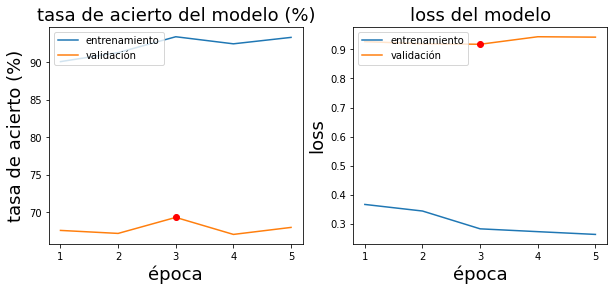

Train on 3500 samples, validate on 750 samples
Epoch 1/1
 512/3500 [===>..........................] - ETA: 16s - loss: 0.2270 - accuracy: 0.9531

KeyboardInterrupt: ignored

In [127]:
batch_size = 512
nepocas = 20

best_val_acc  = 0
best_val_loss = 1e20
best_i        = 0

best_weights = []
acum_tr_acc = []
acum_tr_loss = []
acum_val_acc = []
acum_val_loss = []


for e in range(nepocas):
  h = model.fit(X_train_pad, y_tr_num,
                batch_size=batch_size,
                validation_data=(X_val_pad, y_val_num),
                epochs=1, verbose=1)
  
  acum_tr_acc  = acum_tr_acc  + h.history['accuracy']
  acum_tr_loss = acum_tr_loss + h.history['loss']
  val_acc  = h.history['val_accuracy'][0]
  val_loss = h.history['val_loss'][0]
  acum_val_acc  = acum_val_acc  + [val_acc]
  acum_val_loss = acum_val_loss + [val_loss]
#  if val_acc  > best_val_acc:
  if val_loss < best_val_loss:
    best_i        = len(acum_val_acc)-1
    best_val_acc  = val_acc
    best_val_loss = val_loss
    best_weights = model.get_weights().copy()
  if len(acum_tr_acc)>1 and (len(acum_tr_acc)+1) % 1 == 0:
    if e>1:
      clear_output()
    grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [0]:
model.set_weights(best_weights)

In [0]:
scores = model.evaluate(X_test_pad, y_te_num, verbose=1)
print("Accuracy in test: %.2f%%" % (scores[1]*100))

## Over raw data

<font color="orange"><h1 align="left">Over raw data</h1></font>

In [0]:
# Length of the vocabulary
top_words = 6000

tokenizer = Tokenizer(num_words = top_words,   oov_token = "oov")
tokenizer.fit_on_texts(narratives_tr)
X_train = np.array(tokenizer.texts_to_sequences(narratives_tr))
X_test = np.array(tokenizer.texts_to_sequences(narratives_te))
X_val = np.array(tokenizer.texts_to_sequences(narratives_val))

maxlen = 250
X_train_pad = pad_sequences(X_train, maxlen=maxlen)
X_test_pad = pad_sequences(X_test, maxlen=maxlen)
X_val_pad = pad_sequences(X_val, maxlen=maxlen)


# Add the padding element
int2word[0] = "padding"

In [0]:
embedding_len = 200 # 64 # Length of the embedding vector
neuron_LSTM = 80 # Number of neurones in the hidden layer
neuron_DENSE = 5 # Number of neurones in output layer = Number of classes
p = 0.2 # Dropout probability

# Building LSTM RNN
model = Sequential()

# Embedding layer
model.add(Embedding(top_words, embedding_len, input_length=maxlen))
model.add(Dropout(0.2))
# Hidden layer
model.add(LSTM(neuron_LSTM, dropout=0.2, recurrent_dropout=0.2))
# Output layer
model.add(Dense(neuron_DENSE, activation='softmax')) # Multiple classes
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()
SVG(model_to_dot(model,show_shapes=True,dpi=72).create(prog='dot', format='svg'))

In [0]:
batch_size = 512
nepocas = 20

best_val_acc  = 0
best_val_loss = 1e20
best_i        = 0

best_weights = []
acum_tr_acc = []
acum_tr_loss = []
acum_val_acc = []
acum_val_loss = []

for e in range(nepocas):
  h = model.fit(X_train_pad, y_tr_num,
                batch_size=batch_size,
                validation_data=(X_val_pad, y_val_num),
                epochs=1, verbose=1)
  
  acum_tr_acc  = acum_tr_acc  + h.history['accuracy']
  acum_tr_loss = acum_tr_loss + h.history['loss']
  val_acc  = h.history['val_accuracy'][0]
  val_loss = h.history['val_loss'][0]
  acum_val_acc  = acum_val_acc  + [val_acc]
  acum_val_loss = acum_val_loss + [val_loss]
#  if val_acc  > best_val_acc:
  if val_loss < best_val_loss:
    best_i        = len(acum_val_acc)-1
    best_val_acc  = val_acc
    best_val_loss = val_loss
    best_weights = model.get_weights().copy()
  if len(acum_tr_acc)>1 and (len(acum_tr_acc)+1) % 1 == 0:
    if e>1:
      clear_output()
    grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [0]:
model.set_weights(best_weights)

In [0]:
model.set_weights(best_weights)
scores = model.evaluate(X_test_pad, y_te_num, verbose=1)
print("Accuracy in test: %.2f%%" % (scores[1]*100))

# Simple GRU

In [0]:
embedding_len = 200 # 64 # Length of the embedding vector
neuron_GRU = 80 # Number of neurones in the hidden layer
neuron_DENSE = 5 # Number of neurones in output layer = Number of classes
p = 0.2 # Dropout probability

# Building LSTM RNN
model = Sequential()

# Embedding layer
model.add(Embedding(top_words, embedding_len, input_length=maxlen))
model.add(Dropout(0.2))
# Hidden layer
model.add(GRU(neuron_GRU, dropout=0.2, recurrent_dropout=0.2))
# Output layer
model.add(Dense(neuron_DENSE, activation='softmax')) # Multiple classes
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()
SVG(model_to_dot(model,show_shapes=True,dpi=72).create(prog='dot', format='svg'))

In [0]:
batch_size = 512
nepocas = 20

best_val_acc  = 0
best_val_loss = 1e20
best_i        = 0

best_weights = []
acum_tr_acc = []
acum_tr_loss = []
acum_val_acc = []
acum_val_loss = []

for e in range(nepocas):
  h = model.fit(X_train_pad, y_tr_num,
                batch_size=batch_size,
                validation_data=(X_val_pad, y_val_num),
                epochs=1, verbose=1)
  
  acum_tr_acc  = acum_tr_acc  + h.history['accuracy']
  acum_tr_loss = acum_tr_loss + h.history['loss']
  val_acc  = h.history['val_accuracy'][0]
  val_loss = h.history['val_loss'][0]
  acum_val_acc  = acum_val_acc  + [val_acc]
  acum_val_loss = acum_val_loss + [val_loss]
#  if val_acc  > best_val_acc:
  if val_loss < best_val_loss:
    best_i        = len(acum_val_acc)-1
    best_val_acc  = val_acc
    best_val_loss = val_loss
    best_weights = model.get_weights().copy()
  if len(acum_tr_acc)>1 and (len(acum_tr_acc)+1) % 1 == 0:
    if e>1:
      clear_output()
    grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [0]:
model.set_weights(best_weights)
scores = model.evaluate(X_test_pad, y_te_num, verbose=1)
print("Accuracy in test: %.2f%%" % (scores[1]*100))

## Double GRU

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 250, 200)          2000000   
_________________________________________________________________
lstm_7 (LSTM)                (None, 250, 80)           89920     
_________________________________________________________________
lstm_8 (LSTM)                (None, 80)                51520     
_________________________________________________________________
batch_normalization_6 (Batch (None, 80)                320       
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 405       
Total params: 2,142,165
Trainable params: 142,005
Non-trainable params: 2,000,160
_________________________________________________________________
None


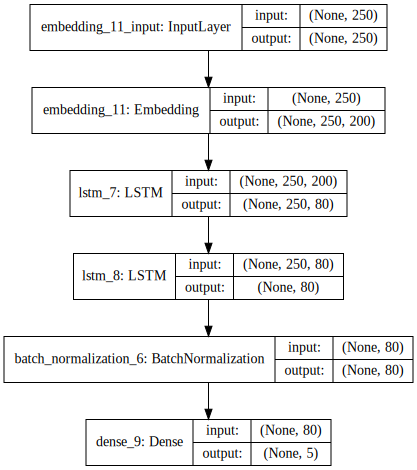

In [146]:
from keras.layers import GlobalAveragePooling1D, BatchNormalization
neuron_GRU = 80 # Number of neurones in the hidden layer
neuron_DENSE = 5 # Number of neurones in output layer = Number of classes
p = 0.2 # Dropout probability
embedding_len = 200

model = Sequential()
model.add(Embedding(top_words, # Vocabulary size
                    embedding_len,  # Embedding size
                    input_length=maxlen,
                    trainable=False))
model.add(LSTM(neuron_GRU, dropout=p,   return_sequences=True))
model.add(LSTM(neuron_GRU, dropout=p))
model.add(BatchNormalization())
model.add(Dense(neuron_DENSE, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #   metrics=[tf.keras.metrics.CategoricalCrossentropy()])

print(model.summary())
SVG(model_to_dot(model,show_shapes=True,dpi=72).create(prog='dot', format='svg'))

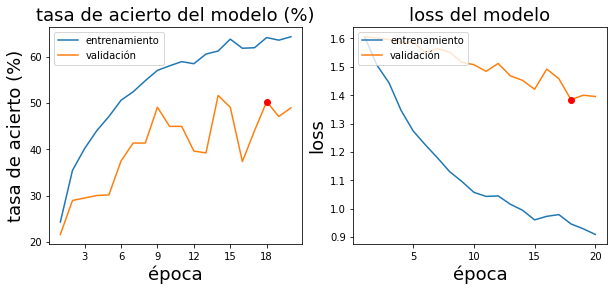

In [147]:
batch_size = 512
nepocas = 20

best_val_acc  = 0
best_val_loss = 1e20
best_i        = 0

best_weights = []
acum_tr_acc = []
acum_tr_loss = []
acum_val_acc = []
acum_val_loss = []

for e in range(nepocas):
  h = model.fit(X_train_pad, y_tr_num,
                batch_size=batch_size,
                validation_data=(X_val_pad, y_val_num),
                epochs=1, verbose=1)
  
  acum_tr_acc  = acum_tr_acc  + h.history['accuracy']
  acum_tr_loss = acum_tr_loss + h.history['loss']
  val_acc  = h.history['val_accuracy'][0]
  val_loss = h.history['val_loss'][0]
  acum_val_acc  = acum_val_acc  + [val_acc]
  acum_val_loss = acum_val_loss + [val_loss]
#  if val_acc  > best_val_acc:
  if val_loss < best_val_loss:
    best_i        = len(acum_val_acc)-1
    best_val_acc  = val_acc
    best_val_loss = val_loss
    best_weights = model.get_weights().copy()
  if len(acum_tr_acc)>1 and (len(acum_tr_acc)+1) % 1 == 0:
    if e>1:
      clear_output()
    grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [148]:
model.set_weights(best_weights)
scores = model.evaluate(X_test_pad, y_te_num, verbose=1)
print("Accuracy in test: %.2f%%" % (scores[1]*100))

750/750 [==============================] - 2s 3ms/step
Accuracy in test: 54.00%
